In [1]:
import os
import sys 
sys.path.append(os.path.abspath('..'))
sys.path.append(os.path.abspath('../../latent_analysis/'))
sys.path.append(os.path.abspath('../../dPCA/python/'))
import LTransform as LT
from get_utils import get_hidden, get_dir
from pathlib import Path
import numpy as np
import torch as th
import plot as plot
import matplotlib.pyplot as plt
import pandas as pd
import PcmPy as pcm
from scipy.spatial.distance import pdist, squareform
import seaborn as sb
import scipy.stats as stats

In [2]:
# Load hidden
folder_name = 'Sim_simple'
n_latent = 7
n_muscle = 6
phase = {'NF1':[0],'FF1':[8],'NF2':[0],'FF2':[8]}
ff_coef = [0,8,0,8]

results = pd.DataFrame()
rdms = []
#tp = np.arange(15)
tp = 15

for mn in range(0,20):
    model_name = "model{:02d}".format(mn)

    weight_file,_,_= get_dir(folder_name,model_name,'NF1',0)
    W = th.load(weight_file)['fc.weight'].numpy()
    U, S, Vh = np.linalg.svd(W, full_matrices=True)
    V = Vh.T
    P = V[:,:n_muscle] # output potent
    N = V[:,n_muscle:] # output null

    data = get_hidden(folder_name,model_name,phase,ff_coef,demean=False)
    
    all_hidden = np.concatenate(data,axis=0)
    all_hidden_subset = all_hidden[:,tp,:]

    X = all_hidden_subset @ N # project on muscle null space
    X = X[:,None,:]

    T = LT.Transform(num_latent=n_latent)
    T.fit(X,method='PCA')
    X_ld = T.transform(X,ensure_orthogonality=True)

    # Apply PCA
    Data_prep =  {'x_ld':[],'x':[]}
    for i in range(len(data)):
        idx = np.arange(8*i,8*(i+1))

        Data_prep['x_ld'].append(X_ld[idx,0,:])
        Data_prep['x'].append(X[idx,0,:])
    
    D = np.stack(Data_prep['x'])
    dims = D.shape
    D = D.reshape(dims[0],-1)
    rdms.append(pdist(D))

In [4]:
diff = (Data_prep['x_ld'][2]-Data_prep['x_ld'][0])

In [5]:
from sklearn.metrics.pairwise import cosine_similarity

# Calculate pairwise cosine similarity
cos_sim = cosine_similarity(diff)
cos_sim = cos_sim[np.tril_indices(cos_sim.shape[0], k=-1)]
cos_sim_deg = np.degrees(np.arccos(np.mean(cos_sim)))
cos_sim_deg


47.22582

In [6]:
np.mean(np.degrees(np.arccos(cos_sim)))

45.783596

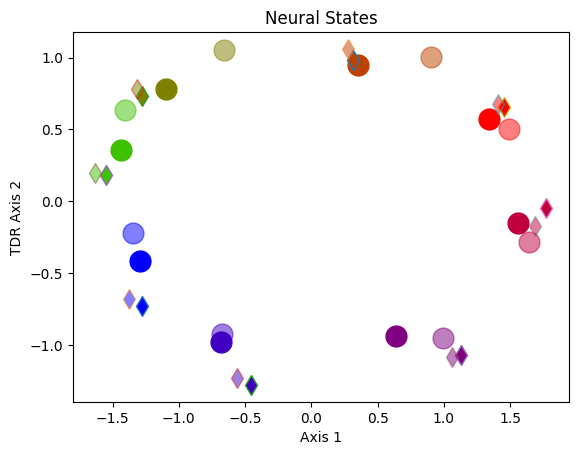

In [3]:
angle_set = np.deg2rad(np.arange(0, 360, 45))  # 8 directions
color_list = [plt.cm.brg(cond / (2 * np.pi)) for cond in angle_set]
n_cond = len(angle_set)

data_p = Data_prep['x_ld']

# Create a scatter plot
plt.figure()

in1=0
in2=1
for i in range(n_cond):
    plt.plot(data_p[0][i,in1], data_p[0][i,in2],'.', markersize=30, color=color_list[i])
    plt.plot(data_p[1][i,in1], data_p[1][i,in2],'d', markersize=10, markerfacecolor=color_list[i])
    plt.plot(data_p[2][i,in1], data_p[2][i,in2],'.', markersize=30, color=color_list[i],alpha=0.5)
    plt.plot(data_p[3][i,in1], data_p[3][i,in2],'d', markersize=10, markerfacecolor=color_list[i],alpha=0.5)
    #plt.plot(data_p[4][i,0], data_p[4][i,1],'>', markersize=10, markerfacecolor=color_list[i],alpha=0.5)

plt.xlabel('Axis 1')
plt.ylabel('TDR Axis 2')
plt.title('Neural States')

plt.show()

# plot MDS

T-statistic: 1.2651648225921361
P-value: 0.22110914813720708


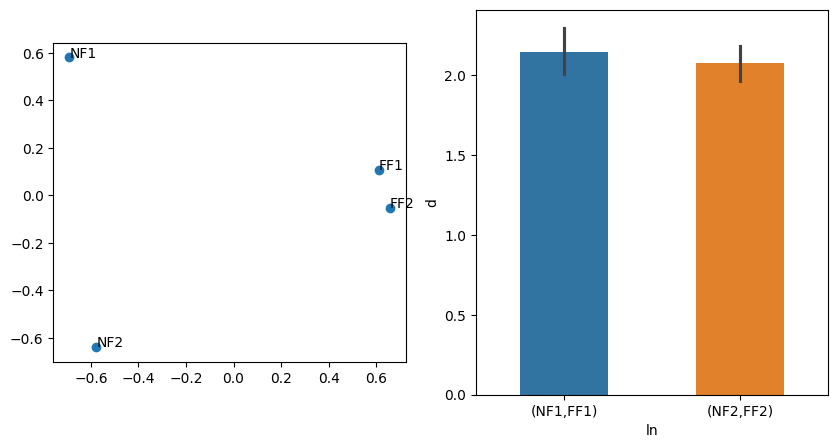

In [4]:
tp = np.arange(15)
labels = ['NF1','FF1','NF2','FF2']

rdm_avg = np.mean(np.stack(rdms,axis=0),axis=0)
rdm_m = squareform(rdm_avg)

n_cond = rdm_m.shape[0]

H = np.eye(n_cond) - np.ones((n_cond,n_cond))/n_cond
G = -0.5*H@rdm_m@H

# np.sum(pcm.G_to_dist(G)-rdm_m) # sanity check
W,Glam = pcm.classical_mds(G)

fig,ax = plt.subplots(1,2,figsize=(10,5))

ax[0].scatter(W[:,0],W[:,1])
for i, label in enumerate(labels):
    ax[0].annotate(label,(W[i,0],W[i,1]))
ax[0].set_aspect('equal')


T = pd.DataFrame()

label = []

for i in range(len(labels)):
    for j in range(i + 1, len(labels)):
        pair = f'({labels[i]},{labels[j]})'
        label.append(pair)
        
#select = [0,7,8]
select = [0,5]
for i in range(len(rdms)):
    for j in select:
        d = {'m':[i],'ln':[label[j]],'d':[rdms[i][j]]}
        T = pd.concat([T,pd.DataFrame(d)],ignore_index=True)
ax[1] = sb.barplot(x='ln',y='d',data=T,hue='ln',width=0.5) # ,order=ho,palette=color ,hue_order=ho

sample1 = T.d[T.ln == '(NF1,FF1)'].to_numpy()
sample2 = T.d[T.ln == '(NF2,FF2)'].to_numpy()
#sample3 = T.d[T.ln == '(NF2,FF2-)'].to_numpy()

# Perform paired t-test
t_statistic, p_value = stats.ttest_rel(sample1, sample2)

print("T-statistic:", t_statistic)
print("P-value:", p_value)

In [5]:
sample2

array([2.30704718, 2.38859571, 2.14439117, 1.90155815, 1.78909592,
       2.08507729, 1.89283214, 2.29992036, 2.70695593, 1.78231357,
       1.99855424, 2.41322435, 1.57741057, 1.82938313, 2.03091703,
       2.11095093, 2.15458825, 1.85989114, 2.17529975, 2.10132978])